In [1]:
from flame_analysis_model import *
from mpi4py import MPI
import matplotlib.pyplot as plt

In [3]:

comm = MPI.COMM_WORLD
rank = comm.rank

time_step = 212
phi = 0.40
lat_size = 100
T_ref = 300
p_ref = 5e05


folder_name = f"data/phi{phi:.2f}/h400x{lat_size}_ref"
file_name = "premix"
# Geometry / reference file (constant)

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= False,
    compute_vel_hessian= False,
    compute_reaction_rates= True,
    cantera_inputs = ["../chemical_mech/BurkeH2.yaml", None, phi, T_ref, p_ref]
)


2025-12-01 15:27:01,210 - Mesh - INFO - Initializing empty Mesh object.
2025-12-01 15:27:01,210 - Field - INFO - Initializing empty Field object
2025-12-01 15:27:01,211 - pynekread - INFO - Reading file: ../data/phi0.40/h400x100_ref/premix0.f00001
2025-12-01 15:27:01,238 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-12-01 15:27:01,239 - Mesh - INFO - Initializing common attributes.
2025-12-01 15:27:01,240 - Mesh - INFO - Getting vertices
2025-12-01 15:27:01,246 - Mesh - INFO - Getting edge centers
2025-12-01 15:27:01,331 - Mesh - INFO - Facet centers not available for 2D
2025-12-01 15:27:01,332 - Mesh - INFO - Mesh object initialized.
2025-12-01 15:27:01,333 - Mesh - INFO - Mesh data is of type: float64
2025-12-01 15:27:01,333 - Mesh - INFO - Elapsed time: 0.09458000000449829s
2025-12-01 15:27:01,333 - pynekread - INFO - Reading field data
2025-12-01 15:27:01,334 - pynekread - INFO - Overwriting fld object
2025-12-01 15:27:01,593 - pynekread - INFO - File read
2025

In [11]:
front = ds.extract_flame_front_unstruct(
    c_level= 3.5,
)
print(front.head())
front.to_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}.csv", index=False )

            x          y    z         v    T        H2        O2       H2O  \
0  204.899797  56.503330  0.0  2.559427  3.5  0.002390  0.169386  0.071223   
1  204.926362  56.451614  0.0  2.533177  3.5  0.002411  0.169404  0.071259   
2  204.847432  56.616249  0.0  2.618043  3.5  0.002334  0.169651  0.071001   
3  204.851303  56.607220  0.0  2.612714  3.5  0.002340  0.169652  0.071007   
4  204.800003  56.762884  0.0  2.701187  3.5  0.002226  0.169784  0.070797   

          H         O  ...      omega_O2     omega_H2O       omega_H  \
0  0.000058  0.000580  ... -5.782943e+14  8.063242e+15 -1.295305e+16   
1  0.000059  0.000585  ... -5.898323e+14  8.206305e+15 -1.322869e+16   
2  0.000055  0.000544  ... -5.766293e+14  7.299199e+15 -1.173463e+16   
3  0.000055  0.000544  ... -5.784649e+14  7.326764e+15 -1.177787e+16   
4  0.000051  0.000524  ... -5.400072e+14  6.599989e+15 -1.056932e+16   

        omega_O      omega_OH     omega_HO2    omega_H2O2  omega_N2    Le_def  \
0 -3.045251e+15 -

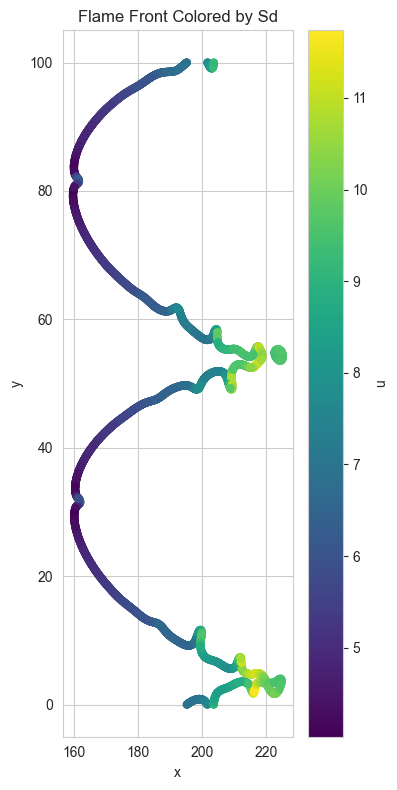

In [10]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    front["x"],
    front["y"],
    c = front["u"],
    cmap = "viridis",
    linewidths=0.01
)
plt.colorbar(sc, label="u")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")
plt.tight_layout()
plt.show()


## Compare to Pyvista - OLD

In [6]:
import pyvista as pv
import numpy as np

## Reading Nek files
filename = "./data/v5/po_premix.nek5000"
reader = pv.get_reader(filename)
time_value = 16
reader.set_active_time_value(time_value)

data = reader.read()
times = np.asarray(reader.time_values)
print(times)
## Plotting
## Filtering Data
## Extract Isolevel
iso = data.contour(isosurfaces=3.5, scalars="Temperature")
pl = pv.Plotter()
#pl.add_mesh(data, opacity=0.85)
pl.add_mesh(iso, color='black', line_width=3)
pl.show()

[ 1.     2.001  3.001  4.001  5.     6.     7.     8.     9.    10.001
 11.001 12.001 13.001 14.001 15.001 16.001 17.001]


Widget(value='<iframe src="http://localhost:63388/index.html?ui=P_0x242ed26c440_0&reconnect=auto" class="pyvis…

C:\Users\alexp\AppData\Local\Temp\ipykernel_10472\686614184.py:17: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


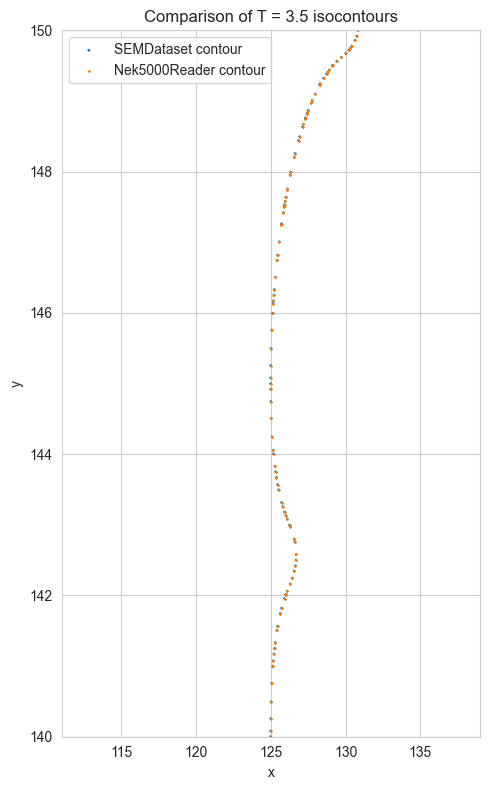

In [7]:
# --- Convert PyVista iso to numpy arrays ---
iso_pts = iso.points        # shape (N_iso, 3)

# --- 2D overlay plot ---
plt.figure(figsize=(5, 8))

# Your SEMDataset-based contour
plt.scatter(
    front["x"], front["y"],
    s=4,
    marker="o",
    edgecolors="none",
    label="SEMDataset contour"
)

# PyVista direct Nek contour
plt.scatter(
    iso_pts[:, 0], iso_pts[:, 1],
    s=1,
    marker="x",
    edgecolors="none",
    label="Nek5000Reader contour"
)

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Comparison of T = {3.5} isocontours")
plt.ylim(140,150)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# After:
# front = ds.extract_flame_front_unstruct(...)
# iso   = data.contour(...)

# Size of your SEMDataset-based contour (DataFrame)
print(f"SEMDataset isocontour: {len(front)} points")

# Size of Nek5000Reader-based contour (PyVista PolyData)
print(f"Nek5000Reader isocontour: {iso.n_points} points, {iso.n_cells} cells")

# If you want the raw shapes as well:
print("front DataFrame columns:", front.columns.tolist())
print("iso.points.shape:", iso.points.shape)
print("iso.lines.shape:", getattr(iso, 'lines', None).shape if hasattr(iso, 'lines') else None)
print("iso.polys.shape:", getattr(iso, 'polys', None).shape if hasattr(iso, 'polys') else None)


SEMDataset isocontour: 4263 points
Nek5000Reader isocontour: 4263 points, 4262 cells
front DataFrame columns: ['x', 'y', 'z', 'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release', 'curvature', 'stretch_rate', 'disp_speed_density_weighted', 'abs_flame_prop_vel_normal', 'flow_velocity_normal', 'flow_velocity_tangential', 'tangential_strain_rate', 'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma', 'vorticity']
iso.points.shape: (4263, 3)
iso.lines.shape: (12786,)
iso.polys.shape: None


## Many Isocontours

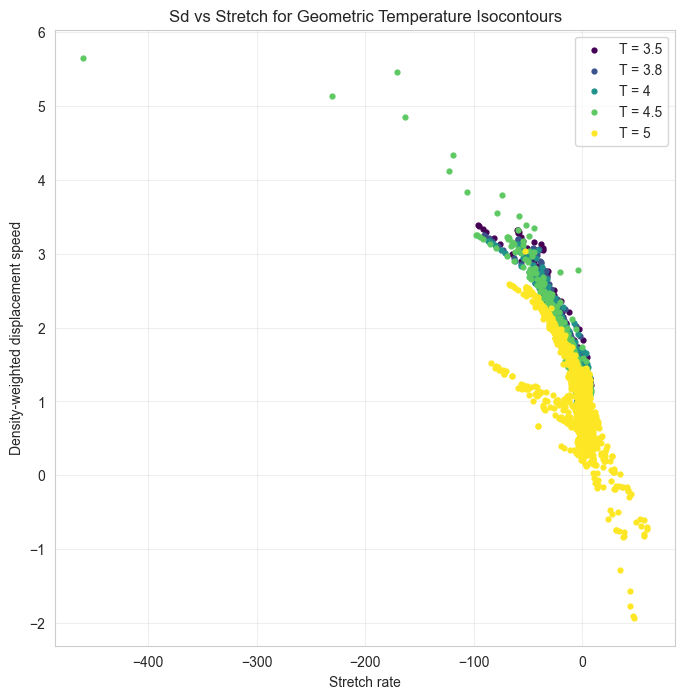

In [9]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):

    # Extract the flame front for this isocontour
    isoline = ds.extract_flame_front_unstruct(
        sample_mode="isocontour",
        c_level=iso,
    )

    x = isoline["stretch_rate"].to_numpy()
    y = isoline["disp_speed_density_weighted"].to_numpy()

    plt.scatter(x, y, s=12, color=colors[i], label=f"T = {iso}")

    # Fit a line if possible
    # if len(x) > 2:
    #     coeffs = np.polyfit(x, y, deg=1)
    #     x_line = np.linspace(x.min(), x.max(), 200)
    #     y_line = coeffs[0] * x_line + coeffs[1]
    #     plt.plot(x_line, y_line, color=colors[i], linewidth=2)

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
# plt.ylim((-5, 5))
# plt.xlim((-200,200))
plt.title("Sd vs Stretch for Geometric Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


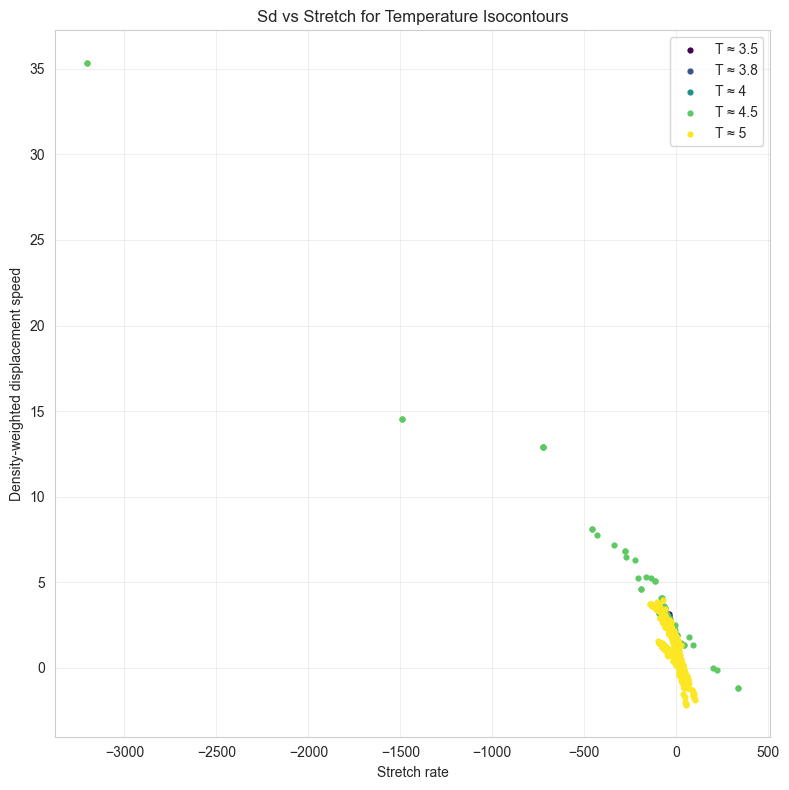

In [10]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]
tol = 0.05
plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis  # choose your preferred colormap
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):
    # Select iso-line slice
    iso_df = df[(df["T"] > (iso - tol)) & (df["T"] < (iso + tol))]

    x = iso_df["stretch_rate"].to_numpy()
    y = iso_df["disp_speed_density_weighted"].to_numpy()

    # Scatter plot
    plt.scatter(x, y, s=12, color=colors[i], label=f"T ≈ {iso}")

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
plt.title("Sd vs Stretch for Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




## OLD

In [24]:
front_old = ds.extract_flame_front_old(
    sample_mode= "progress",
    c_level= 0.51,
    tol= 0.35
)
print(front_old)
print("Extarcted flame front")
front_old.to_csv(f"extracted_flame_front_{time_step}.csv", index=False)

                  x          y          u         v         T            H2  \
11127    364.123047  95.967743  10.487868 -0.128807  4.426628  1.000297e-07   
11135    364.071869  95.967743  10.486437 -0.129190  4.426384  1.004250e-07   
11194    363.436432  95.967743  10.469288 -0.131331  4.426653  1.059165e-07   
11195    363.589111  95.967743  10.473248 -0.131218  4.426034  1.044985e-07   
11196    363.756195  95.967743  10.477721 -0.130821  4.425757  1.030176e-07   
...             ...        ...        ...       ...       ...           ...   
1315633  283.381927  20.213009   2.861038 -1.043504  2.143348  4.865834e-03   
1315634  283.270142  20.213009   2.347739 -1.267220  1.737864  5.873242e-03   
1315640  283.433136  20.161291   2.964994 -0.999817  2.214789  4.703499e-03   
1315641  283.381927  20.161291   2.712486 -1.118868  2.012505  5.158657e-03   
1315642  283.270142  20.161291   2.240086 -1.320497  1.639641  6.161300e-03   

               O2       H2O             H          

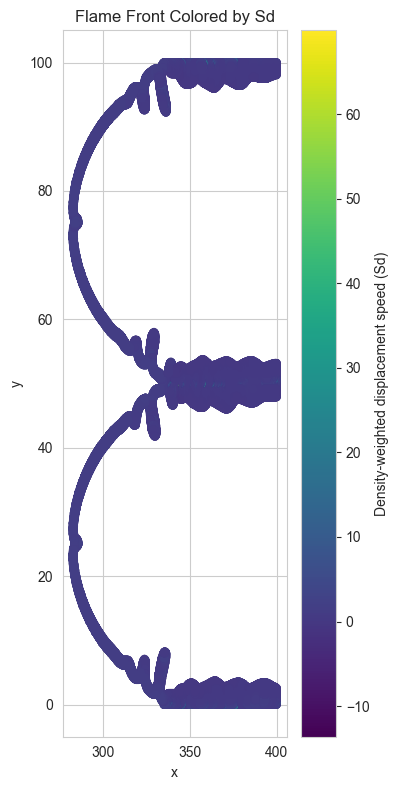

In [28]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    front_old["x"],
    front_old["y"],
    c = front_old["disp_speed_density_weighted"],
    cmap = "viridis",
    linewidths = 0.1
)


plt.colorbar(sc, label="Density-weighted displacement speed (Sd)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
num_cols = df.select_dtypes(include='number').columns.intersection(
    front.select_dtypes(include='number').columns
)

desc_df    = front[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])
desc_front = front_old[num_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

# Put them side-by-side
desc_both = pd.concat(
    {'front': desc_df, 'front_old': desc_front},
    axis=1
)

print(desc_both)


             front                                                       \
                 x            y             T           H2           O2   
count  4099.000000  4099.000000  4.099000e+03  4099.000000  4099.000000   
mean    310.795633    50.174180  3.500000e+00     0.001820     0.170606   
std      18.907244    30.724066  1.105608e-16     0.000683     0.002585   
min     281.579419     0.000000  3.500000e+00     0.000039     0.160502   
1%      282.685871     0.834385  3.500000e+00     0.000043     0.163919   
5%      283.302564     2.408846  3.500000e+00     0.000325     0.166100   
50%     310.681946    49.801762  3.500000e+00     0.001910     0.170927   
95%     339.956757    98.168351  3.500000e+00     0.002612     0.175781   
99%     345.105725    99.489594  3.500000e+00     0.004082     0.176645   
max     345.965608   100.000000  3.500000e+00     0.004543     0.177035   

                                                                          ...  \
               H2O

In [ ]:
from pysemtools.postprocessing.plotting import isosurfaces
# Build mesh dict exactly as the function expects
mesh_dict = {
    "x": ds.x.reshape(-1),
    "y": ds.y.reshape(-1),
    "z": ds.z.reshape(-1),
}

# Choose which field(s) you want isosurfaces for – here: temperature T
fields_dict = {
    "T": ds.t.reshape(-1),   # same shape as mesh coords
}
print(ds.t.shape)
# Define the isosurface levels for each field
isos_dict = {
    "T": np.array([3.5, 3.8, 4.0, 4.5, 5.0]),
}

# Call the pySEMtools helper
plotters = isosurfaces(
    mesh=mesh_dict,
    fields=fields_dict,
    isosurfaces=isos_dict,
    shape=(1, len(isos_dict["T"])),
    colormap="viridis",
    opacity=1.0,
)

# Show each plotter (depending on how you run your code)
for pl in plotters:
    pl.show()